In [1]:
import json 
import pandas as pd

def load_ratings(folder, category):
    training_file, testing_file = f"{folder}/{category}_Ratings_training.csv",  f"{folder}/{category}_Ratings_test.csv"
    training_ratings, testing_ratings = pd.read_csv(training_file), pd.read_csv(testing_file)
    return training_ratings, testing_ratings

def load_json(file):
    with open(file,"r") as f:
        data = f.read()
    json_data = []
    for d in data.split("\n"):
        json_data.append(json.loads(d))
    return json_data

def load_reviews(folder, category):
    training_file, testing_file = f"{folder}/{category}_Reviews_training.json",  f"{folder}/{category}_Reviews_test.json"
    training_reviews, testing_reviews = pd.read_json(training_file,lines=True), pd.read_json(testing_file,lines=True)
    return training_reviews, testing_reviews

In [2]:
trn_ratings, tst_ratings = load_ratings("./ML_datasets/ML_datasets", "Automotive")
trn_reviews, tst_reviews = load_reviews("./ML_datasets/ML_datasets", "Automotive")

## Awesome 0: 
Just the mean values of all overall score.

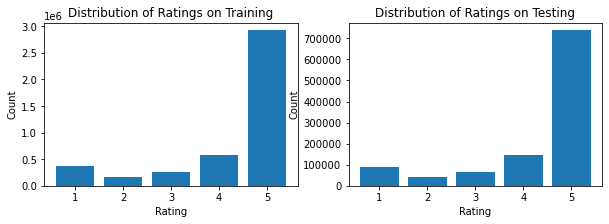

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# compute rating distribution
trn_counts = trn_ratings['overall'].value_counts().sort_index()
tst_counts = tst_ratings['overall'].value_counts().sort_index()

# plot rating distribution
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 3))

ax0.bar(trn_counts.index, trn_counts.values)
ax0.set_xlabel('Rating')
ax0.set_ylabel('Count')
ax0.set_title('Distribution of Ratings on Training')

ax1.bar(tst_counts.index, tst_counts.values)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Ratings on Testing')

plt.show()

## Awesome 1: verified reviewers' rating

To define the awesomeness of a product from the provided Amazon review and rating datasets, we can define it as the weighted average of the overall ratings where the weights are determined by the verified status of the reviewer. The assumption here is that the ratings from verified reviewers are more reliable than those from non-verified reviewers.

Here is the code to compute the awesomeness of each product:

In [157]:
tst_awesomeness1 = tst_ratings.merge(tst_reviews[['asin', 'reviewerID', 'verified']], on=['asin', 'reviewerID'])\
.groupby('asin')\
.apply(lambda x: (x['overall'] * x['verified']).sum() / x['verified'].sum())\
.rename('awesomeness')\
.reset_index()

<ipython-input-157-c7db62ea0e9c>:3: RuntimeWarning: invalid value encountered in double_scalars
  .apply(lambda x: (x['overall'] * x['verified']).sum() / x['verified'].sum())\


In [158]:
trn_awesomeness1 = trn_ratings.merge(trn_reviews[['asin', 'reviewerID', 'verified']], on=['asin', 'reviewerID'])\
.groupby('asin')\
.apply(lambda x: (x['overall'] * x['verified']).sum() / x['verified'].sum())\
.rename('awesomeness')\
.reset_index()

<ipython-input-158-61916ace8649>:3: RuntimeWarning: invalid value encountered in double_scalars
  .apply(lambda x: (x['overall'] * x['verified']).sum() / x['verified'].sum())\


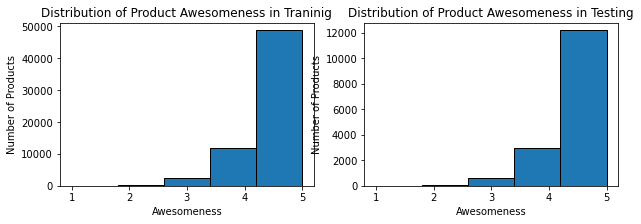

In [159]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 3))

ax0.hist(list(trn_awesomeness1['awesomeness']), bins=5, edgecolor='black')
ax0.set_xlabel('Awesomeness')
ax0.set_ylabel('Number of Products')
ax0.set_title('Distribution of Product Awesomeness in Traninig')

ax1.hist(list(tst_awesomeness1['awesomeness']), bins=5, edgecolor='black')
ax1.set_xlabel('Awesomeness')
ax1.set_ylabel('Number of Products')
ax1.set_title('Distribution of Product Awesomeness in Testing')

plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(list(tst_awesomeness['awesomeness']), bins=5, edgecolor='black')
# plt.xlabel('Awesomeness')
# plt.ylabel('Number of Products')
# plt.title('Distribution of Product Awesomeness in Testing')
# plt.show()

## Awesome 2: Rating Distribution

Rating distribution: You can analyze the distribution of ratings for the product. For example, if most of the ratings are 5 stars, you can consider the product to be awesome. On the other hand, if most of the ratings are 1 or 2 stars, you can consider the product to be not so awesome. Then we can define awesomeness as the raios of postive review.

In [17]:
awesome_standard = 4.0

tst_awesomeness2 = tst_ratings.groupby("asin").apply(lambda x: sum(x['overall']>awesome_standard)/sum(x['overall']>0))\
.rename("awesomeness").reset_index()

trn_awesomeness2 = trn_ratings.groupby("asin").apply(lambda x: sum(x['overall']>awesome_standard)/sum(x['overall']>0))\
.rename("awesomeness").reset_index()

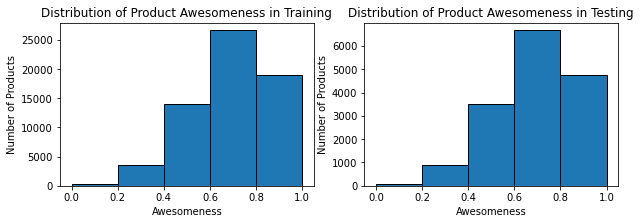

In [18]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 3))

ax0.hist(list(trn_awesomeness2['awesomeness']), bins=5, edgecolor='black')
ax0.set_xlabel('Awesomeness')
ax0.set_ylabel('Number of Products')
ax0.set_title('Distribution of Product Awesomeness in Training')

ax1.hist(list(tst_awesomeness2['awesomeness']), bins=5, edgecolor='black')
ax1.set_xlabel('Awesomeness')
ax1.set_ylabel('Number of Products')
ax1.set_title('Distribution of Product Awesomeness in Testing')

plt.show()

## Awesome3: sentiment analysis

we can use Natural Language Processing (NLP) techniques to perform sentiment analysis on the review text. This will help you determine whether the reviews are positive, negative or neutral. You can then calculate the mean of sentiment score to define the awesomeness of the product. 

In [4]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

In [5]:
def analyze_sentiment(reviews_df):
    df_copy = reviews_df.copy()
    
    # Preprocess the review text
    stop_words = set(stopwords.words('english'))
    def preprocess_text(text):
        if type(text) == float:
            print(text)
        tokens = word_tokenize(text.lower())
        tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
        return ' '.join(tokens)
    df_copy['reviewText'] = reviews_df['reviewText'].astype(str).apply(preprocess_text)

    # initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # calculate sentiment scores for each review
    sentiment_scores = df_copy["reviewText"].astype(str).apply(lambda x: sia.polarity_scores(x))

    # extract compound score, -1 means negative, +1 means positive
    df_copy["sentiment"] = [score["compound"] for score in sentiment_scores]

    # calculate average sentiment for each product
    avg_sentiments = df_copy.groupby("asin")["sentiment"].mean().rename("awesomeness").reset_index()
    return avg_sentiments

In [13]:
tst_sentiments = analyze_sentiment(tst_reviews)

In [14]:
trn_sentiments = analyze_sentiment(trn_reviews)

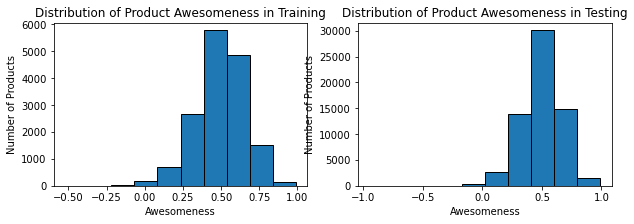

In [16]:
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10, 3))

ax0.hist(list(tst_sentiments['awesomeness']), bins=10, edgecolor='black')
ax0.set_xlabel('Awesomeness')
ax0.set_ylabel('Number of Products')
ax0.set_title('Distribution of Product Awesomeness in Training')

ax1.hist(list(trn_sentiments['awesomeness']), bins=10, edgecolor='black')
ax1.set_xlabel('Awesomeness')
ax1.set_ylabel('Number of Products')
ax1.set_title('Distribution of Product Awesomeness in Testing')

plt.show()